# ***Problem Statement***
The objective is to analyze drug safety, usage, and patient experiences and to build a machine learning model that predicts the patient rating of a drug using features like side effects, drug classes, activity levels, and safety parameters.



focusing on:

* What factors influence drug ratings?

* Which side effects are most common?

* Can ratings be predicted using drug properties and patient-reported outcomes?

***1.Import Libraries***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# *Data Description*
The dataset contains information about drugs, their medical uses, side effects, safety categories, reviews, and ratings.
It includes both structured attributes (e.g., activity %, number of reviews, alcohol interaction) and text attributes (e.g., side effects, drug classes).
This combination enables both numerical and NLP-based feature engineering for predictive modelling.

Key columns:

* drug_name – Name of the drug

* generic_name – Generic version name

* medical_condition – Condition for which drug is prescribed

* side_effects – Reported side effects (text)

* drug_classes – Pharmacological category

* rating – Average patient rating

* no_of_reviews – Number of submitted reviews

* activity – Effectiveness percentage

* pregnancy_category – Safety in pregnancy

* alcohol – Whether the drug interacts with alcohol (X/0)

* rx_otc – Whether it requires prescription

***2. Load Dataset***

In [2]:
df = pd.read_csv('drugs_side_effects_drugs_com.csv')
print(df.shape)
df.head()


(2931, 17)


,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,X,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,NaN,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",NaN,41%,Rx,X,N,X,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.9,623.0,https://www.drugs.com/accutane.html,https://www.drugs.com/condition/acne.html
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives","Cleocin T, Clindacin ETZ, Clindacin P, Clindag...",39%,Rx,B,N,NaN,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.4,146.0,https://www.drugs.com/mtm/clindamycin-topical....,https://www.drugs.com/condition/acne.html


***3. Basic Info & Missing Values***

In [3]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drug_name                      2931 non-null   object 
 1   medical_condition              2931 non-null   object 
 2   side_effects                   2807 non-null   object 
 3   generic_name                   2888 non-null   object 
 4   drug_classes                   2849 non-null   object 
 5   brand_names                    1718 non-null   object 
 6   activity                       2931 non-null   object 
 7   rx_otc                         2930 non-null   object 
 8   pregnancy_category             2702 non-null   object 
 9   csa                            2931 non-null   object 
 10  alcohol                        1377 non-null   object 
 11  related_drugs                  1462 non-null   object 
 12  medical_condition_description  2931 non-null   o

,0
drug_name,0
medical_condition,0
side_effects,124
generic_name,43
drug_classes,82
brand_names,1213
activity,0
rx_otc,1
pregnancy_category,229
csa,0


***4. Clean & Standardize Columns***

In [4]:

if 'brand_names' in df.columns:
    df = df.drop(columns=['brand_names'])


if 'activity' in df.columns:
    df['activity'] = df['activity'].astype(str).str.rstrip('%')
    df['activity'] = pd.to_numeric(df['activity'], errors='coerce') / 100


for c in ['rating', 'no_of_reviews']:
    df[c] = pd.to_numeric(df[c], errors='coerce')


fill_cols = ['side_effects','related_drugs','generic_name','drug_classes',
             'rx_otc','pregnancy_category']
for c in fill_cols:
    df[c] = df[c].fillna('Unknown')

if 'alcohol' in df.columns:
    df['alcohol'] = df['alcohol'].fillna('0').replace({'X':1,'0':0}).astype(int)

df.head()


/tmp/ipython-input-2564485720.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['alcohol'] = df['alcohol'].fillna('0').replace({'X':1,'0':0}).astype(int)


,drug_name,medical_condition,side_effects,generic_name,drug_classes,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines",0.87,Rx,D,N,1,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...",0.82,Rx,C,N,1,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,0.48,Rx,D,N,0,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",0.41,Rx,X,N,1,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.9,623.0,https://www.drugs.com/accutane.html,https://www.drugs.com/condition/acne.html
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives",0.39,Rx,B,N,0,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.4,146.0,https://www.drugs.com/mtm/clindamycin-topical....,https://www.drugs.com/condition/acne.html


***5. Text Processing: Extract Side Effects***

In [5]:
def split_list(s):
    if pd.isna(s): return []
    return [p.strip() for p in re.split('[;]', str(s)) if p.strip()]

side_series = df['side_effects'].apply(split_list).explode()
top_side = side_series.value_counts().head(20)
top_side


,count
side_effects,
hives,1788
difficult breathing,1130
difficulty breathing,450
itching,275
"a light-headed feeling, like you might pass out",272
unusual hoarseness,266
"red, swollen, blistered, or peeling skin with or without fever",266
tightness in the chest or throat,266
wheezing,266


***6. Basic EDA Plots***

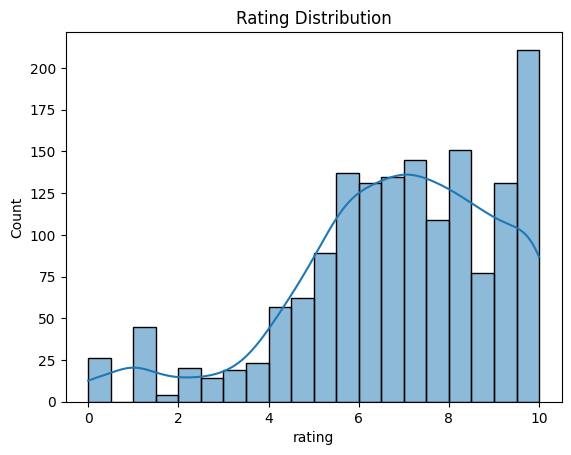

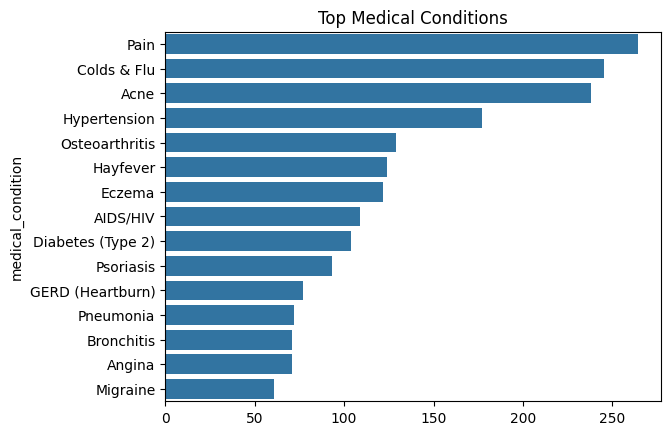

In [6]:
sns.histplot(df['rating'], bins=20, kde=True)
plt.title("Rating Distribution")
plt.show()

top_conditions = df['medical_condition'].value_counts().head(15)
sns.barplot(y=top_conditions.index, x=top_conditions.values)
plt.title("Top Medical Conditions")
plt.show()


***7. Create Boolean Feature Flags***

In [24]:
df['has_hives'] = df['side_effects'].str.lower().str.contains('hives')
df['has_difficulty_breathing'] = df['side_effects'].str.lower().str.contains('difficult')
df['has_itching'] = df['side_effects'].str.lower().str.contains('itch')

df[['side_effects','has_hives','has_difficulty_breathing','has_itching']].head()


,side_effects,has_hives,has_difficulty_breathing,has_itching
0,"(hives, difficult breathing, swelling in your ...",True,True,True
1,hives ; difficulty breathing; swelling of your...,True,True,False
2,"skin rash, fever, swollen glands, flu-like sym...",False,False,True
3,problems with your vision or hearing; muscle o...,False,False,False
4,hives ; difficult breathing; swelling of your ...,True,True,True


***8. Encode & Select Features***

In [15]:
enc = LabelEncoder()

for c in ['pregnancy_category','csa','rx_otc','medical_condition']:
    df[c+'_enc'] = enc.fit_transform(df[c].astype(str))

features = [
    'activity','no_of_reviews','alcohol',
    'has_hives','has_difficulty_breathing','has_itching',
    'pregnancy_category_enc','csa_enc','rx_otc_enc','medical_condition_enc'
]

# Drop rows where 'rating' is NaN from df and create a true copy to prevent SettingWithCopyWarning issues
df_cleaned = df.dropna(subset=['rating']).copy()

# Impute missing 'no_of_reviews' values with the mean
# Using .loc for safe assignment to avoid future SettingWithCopyWarning messages
mean_no_of_reviews = df_cleaned['no_of_reviews'].mean()
df_cleaned.loc[:, 'no_of_reviews'] = df_cleaned['no_of_reviews'].fillna(mean_no_of_reviews)

X = df_cleaned[features].astype(float)
y = df_cleaned['rating'].astype(float)

print(X.shape, y.shape)
# Verification step: Ensure no NaNs remain in X or y
print("\nChecking for NaNs after all processing:")
print("NaNs in X:\n", X.isna().sum().sum()) # Sum of all NaNs in X
print("NaNs in y:\n", y.isna().sum())     # NaNs in y (should be 0)

(1586, 10) (1586,)

Checking for NaNs after all processing:
NaNs in X:
 0
NaNs in y:
 0


***9. Train–Test Split + Scaling***

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


***10. Train RandomForest Model***

In [19]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_s, y_train)

y_pred = rf.predict(X_test_s)


***11. Evaluate Model***

In [20]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", mse**0.5)
print("R2:", r2)


MSE: 4.928584653560357
RMSE: 2.2200415882501745
R2: 0.11649905436048658


***12. Cross-Validation***

In [21]:
cv = cross_val_score(rf, scaler.fit_transform(X), y, cv=5, scoring='r2')
print("CV Mean R2:", cv.mean())


CV Mean R2: -0.2833862780980977


***13. Feature Importance***

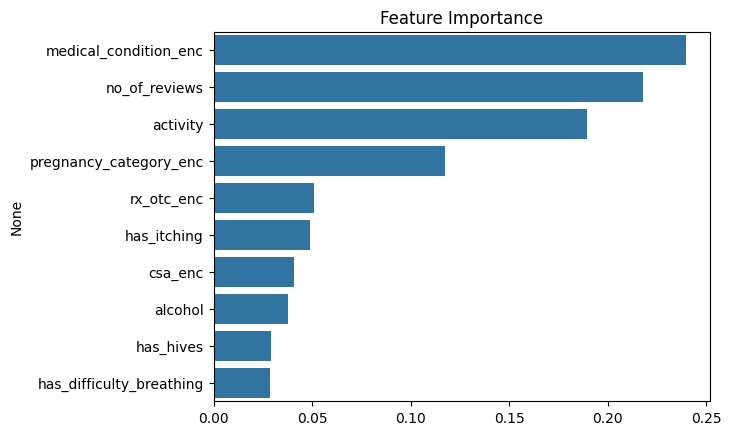

In [22]:
imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
imp
sns.barplot(x=imp.values, y=imp.index)
plt.title("Feature Importance")
plt.show()


***14. Save Cleaned Data & Mode***

In [23]:
df.to_csv('cleaned_drugs_data.csv', index=False)

import joblib
joblib.dump(rf, 'drug_rating_model.joblib')
joblib.dump(scaler, 'rf_scaler.joblib')


['rf_scaler.joblib']

# ***Model Explanation***
 bar chart displays the Feature Importance for the RandomForestRegressor model that was trained to predict drug ratings. Here's what it tells us:

* ***What it represents:*** Each bar indicates the relative importance of a specific feature in determining the drug rating. A longer bar signifies that the corresponding feature had a greater impact on the model's predictions.

* ***Key Observations:***
  * `medical_condition_enc `(encoded medical condition) is by far the most
influential feature, suggesting that the medical condition a drug is prescribed for is the strongest predictor of its rating.
   * `no_of_reviews `(number of reviews) and `activity` (effectiveness percentage) are also highly important factors, indicating that patient engagement and perceived efficacy play a significant role.
   * `pregnancy_category_enc` and `rx_otc_enc `(prescription status) show moderate importance.
   * Features related to specific side effects like `has_itching`, `has_hives`, and `has_difficulty_breathing,` along with `alcohol` interaction and `csa_enc`, have lower importance compared to the top features.

# ***Conclusion:***
The model provides initial insights into factors influencing drug ratings, with medical condition, review volume, and activity being dominant. However, the low R² scores suggest that the current feature set and model complexity may not fully capture the variability in drug ratings, indicating potential for further feature engineering or alternative modeling approaches.

